# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [54]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

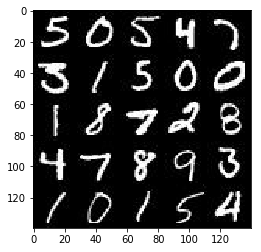

In [55]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
mnist_batch = mnist_images
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

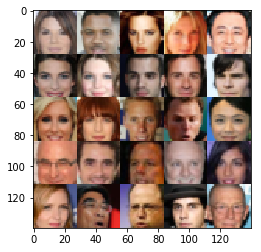

In [56]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
celeb_batch = mnist_images
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [58]:
print(celeb_batch[0].shape)
print(mnist_batch[0].shape)

(28, 28, 3)
(28, 28, 1)


In [59]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs')
    z = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


## Settings ##

In [68]:
# Our kernel size
kernel_size = 5
# Lazy alpha to softly clip negative values
alpha = 0.2
# Initial convolution depth
initial_conv_depth = 64
# Label smoothing rate
smoothing_rate = 0.1
# Total count of convolution layers
layer_count = 4
# The size of the images to be awaited
image_axis_size = 28

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [69]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv_depth = initial_conv_depth
        
        tar_size = image_axis_size//4 # out target image will be 7x7
        
        # Input layer is 28x28xDims
        cur_size = image_axis_size #28
        layer0_conv = tf.layers.conv2d(images, conv_depth, kernel_size, strides=2, padding='same')
        layer0_lazy_relu = tf.maximum(layer0_conv*alpha, layer0_conv)
        cur_layer = layer0_lazy_relu

        # first step without normalization resized it to 14x14x64
        cur_size = cur_size//2
        
        # for all other equal steps attach a set of convolution, normalization and lazy relu
        for index in range(layer_count-1):
            conv_depth *= 2 # convolutional layers always double
            cur_stride = 1 # stride of 1 by default
            
            if cur_size>tar_size: # if we are still allowed to half the size, use a stride of 2
                cur_stride = 2
                cur_size = cur_size//2
            
            cur_layer = tf.layers.conv2d(cur_layer, conv_depth, kernel_size, strides=cur_stride, padding='same')
            cur_layer = tf.layers.batch_normalization(cur_layer, training=True)
            cur_layer = tf.maximum(cur_layer*alpha, cur_layer)

        # flatten the last layer and then fully connect it to a classification boolean discrimanting between real and
        # generated
        flattened = tf.reshape(cur_layer, (-1, tar_size*tar_size*conv_depth))
        logits = tf.layers.dense(flattened, 1)
        # apply sigmoid to get everything into a 0..1 range
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [70]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=True if is_train==False else False):
        
        # Definitions        
        init_2d_size = image_axis_size//4
        init_depth = 512
        target_size = image_axis_size # result shall be 28x28 again
        first_conv_layer_size = init_2d_size*init_2d_size*init_depth
        layer0_densed_z = tf.layers.dense(z, first_conv_layer_size)

        cur_depth = init_depth

        # reshape from a one dimensional array of data for the pixels to a 3 dimensional array again
        layer0_reshaped = tf.reshape(layer0_densed_z, (-1,init_2d_size,init_2d_size,init_depth))
        layer0_normalized = tf.layers.batch_normalization(layer0_reshaped, training=is_train)
        layer0_lazy_relu = tf.maximum(layer0_normalized*alpha,layer0_normalized)
        
        # reconstruct the strides of the discrimnator process
        cur_size = image_axis_size
        tar_size = image_axis_size/4
        
        strides = []
        
        for index in range(layer_count):            
            cur_stride = 1
            
            if cur_size>tar_size:
                cur_stride = 2
                cur_size = cur_size//2
                
            strides.append(cur_stride)
            
        # setup the center convolutional layers
        cur_layer = layer0_lazy_relu
        
        for index in range(layer_count-1):    
            cur_depth = cur_depth//2
            cur_stride = strides[len(strides)-1-index]
            cur_layer = tf.layers.conv2d_transpose(cur_layer, cur_depth, kernel_size, strides=cur_stride, padding='same')
            cur_layer = tf.layers.batch_normalization(cur_layer, training=is_train)
            cur_layer = tf.maximum(cur_layer*alpha, cur_layer)

        # Output layer, 28x28xDim again
        logits = tf.layers.conv2d_transpose(cur_layer, out_channel_dim, kernel_size, strides=2, padding='same')
        # now 28x28x3 or 28x28x1 again
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [71]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1.0 - smoothing_rate)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [72]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # receive all trainable variables
    t_vars = tf.trainable_variables()
    
    # isolate discriminator and generator variables
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # setup adam optimizers for both
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [73]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [77]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # collect samples and losses for logging purposes
    samples, losses = [], []
    
    # total count of steps done
    steps = 0
    
    # steps at which the current generator state shall be visualized
    log_steps_every = 100
    print_every = 20
    
    channel_count = 3 if data_image_mode=='RGB' else 1
    
    learning_rate_value = learning_rate
    
    # Fetch input image size
    image_width = data_shape[2]
    image_height = data_shape[1]

    # Setup inputs
    input_real, input_z, learning_rate = model_inputs(image_width, image_height, channel_count, z_dim)
    # Setup loss functions
    d_loss, g_loss = model_loss(input_real, input_z, channel_count)
    # Setup optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    # Start the training 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # increase step counter
                steps += 1
                
                # rescale the images from -0.5 to +0.5 to -1.0 to +1.0
                batch_images *= 2
                
                # create random noise fir the generator with the same sample count as the real image's count
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers each turn - discriminator first - generator second
                _ = sess.run(d_opt, feed_dict={learning_rate: learning_rate_value, input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={learning_rate: learning_rate_value, input_z: batch_z, input_real: batch_images})

                # print losses at the end of each epoch
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({learning_rate: learning_rate_value, input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({learning_rate: learning_rate_value, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                # show the current image status regularly
                if steps%log_steps_every==0:
                    show_generator_output(sess, show_n_images, input_z, channel_count, data_image_mode)
    
        # show the final image status
        show_generator_output(sess, show_n_images, input_z, channel_count, data_image_mode)
    return

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 7.7618
Epoch 1/2... Discriminator Loss: 5.8446... Generator Loss: 0.0124
Epoch 1/2... Discriminator Loss: 0.7242... Generator Loss: 2.9556
Epoch 1/2... Discriminator Loss: 0.6560... Generator Loss: 1.8533
Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 2.6283


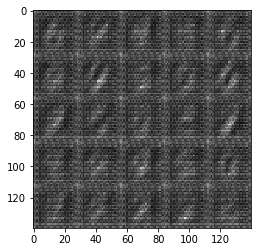

Epoch 1/2... Discriminator Loss: 0.6387... Generator Loss: 3.2900
Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 1.5114
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 3.6744
Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 2.3564
Epoch 1/2... Discriminator Loss: 0.7354... Generator Loss: 1.9105


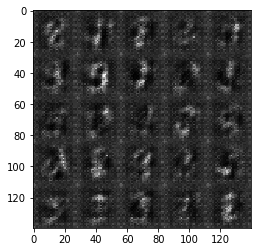

Epoch 1/2... Discriminator Loss: 1.0927... Generator Loss: 4.3784
Epoch 1/2... Discriminator Loss: 0.5612... Generator Loss: 2.0536
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 4.3619
Epoch 1/2... Discriminator Loss: 0.6719... Generator Loss: 2.7872
Epoch 1/2... Discriminator Loss: 1.5037... Generator Loss: 0.5559


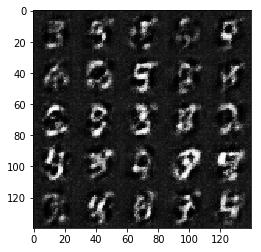

Epoch 1/2... Discriminator Loss: 1.9391... Generator Loss: 0.3779
Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 1.0315
Epoch 1/2... Discriminator Loss: 0.6667... Generator Loss: 1.5747
Epoch 1/2... Discriminator Loss: 0.8270... Generator Loss: 1.2127
Epoch 1/2... Discriminator Loss: 0.8241... Generator Loss: 1.2559


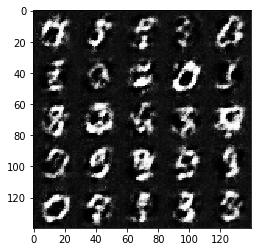

Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.2177
Epoch 1/2... Discriminator Loss: 0.5398... Generator Loss: 2.6268
Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 0.9208
Epoch 1/2... Discriminator Loss: 0.5891... Generator Loss: 2.9643
Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 1.3355


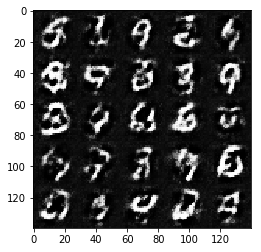

Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 1.6505
Epoch 1/2... Discriminator Loss: 0.6006... Generator Loss: 2.3745
Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 1.3462
Epoch 1/2... Discriminator Loss: 0.5769... Generator Loss: 2.0196
Epoch 1/2... Discriminator Loss: 0.6008... Generator Loss: 1.8212


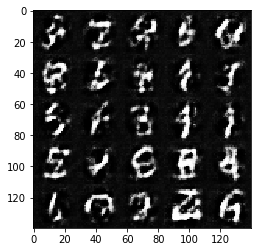

Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 1.0434
Epoch 1/2... Discriminator Loss: 0.5515... Generator Loss: 2.7884
Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 0.9753
Epoch 1/2... Discriminator Loss: 0.6407... Generator Loss: 1.8053
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 0.8678


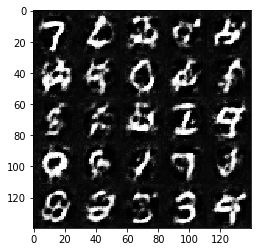

Epoch 1/2... Discriminator Loss: 0.6467... Generator Loss: 1.6076
Epoch 1/2... Discriminator Loss: 0.7130... Generator Loss: 1.3582
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 1.0058
Epoch 1/2... Discriminator Loss: 2.7907... Generator Loss: 0.2253
Epoch 1/2... Discriminator Loss: 0.8553... Generator Loss: 1.1465


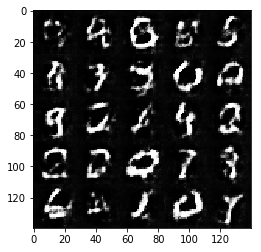

Epoch 1/2... Discriminator Loss: 0.6262... Generator Loss: 1.6846
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 0.5819
Epoch 1/2... Discriminator Loss: 0.6135... Generator Loss: 1.8477
Epoch 1/2... Discriminator Loss: 0.6932... Generator Loss: 1.9541
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.8357


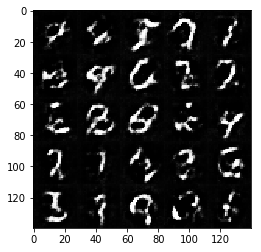

Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 0.7284
Epoch 2/2... Discriminator Loss: 0.6892... Generator Loss: 1.9625
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 1.1315
Epoch 2/2... Discriminator Loss: 0.6097... Generator Loss: 1.8243
Epoch 2/2... Discriminator Loss: 0.6927... Generator Loss: 1.5527


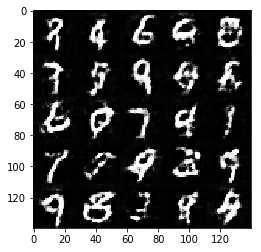

Epoch 2/2... Discriminator Loss: 5.0326... Generator Loss: 6.8937
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 1.2615
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 0.9131
Epoch 2/2... Discriminator Loss: 0.6059... Generator Loss: 2.1232
Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 2.0240


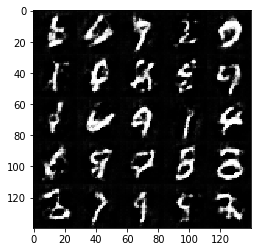

Epoch 2/2... Discriminator Loss: 0.7732... Generator Loss: 1.1728
Epoch 2/2... Discriminator Loss: 0.6978... Generator Loss: 1.4943
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.4432
Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 0.6685... Generator Loss: 2.5103


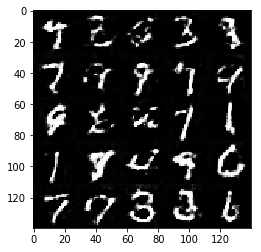

Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 2.1421
Epoch 2/2... Discriminator Loss: 0.6630... Generator Loss: 1.8249
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 1.0574
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.6604
Epoch 2/2... Discriminator Loss: 0.8295... Generator Loss: 1.1062


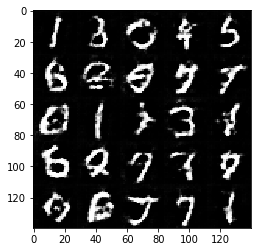

Epoch 2/2... Discriminator Loss: 1.3158... Generator Loss: 1.1400
Epoch 2/2... Discriminator Loss: 0.9563... Generator Loss: 0.9317
Epoch 2/2... Discriminator Loss: 0.7386... Generator Loss: 1.4015
Epoch 2/2... Discriminator Loss: 0.5602... Generator Loss: 2.0993
Epoch 2/2... Discriminator Loss: 0.8899... Generator Loss: 1.0362


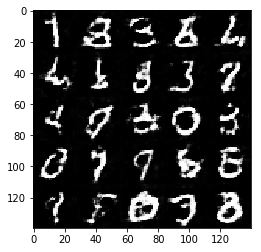

Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.6225
Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 2.4062
Epoch 2/2... Discriminator Loss: 0.7075... Generator Loss: 1.4593
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 0.6168


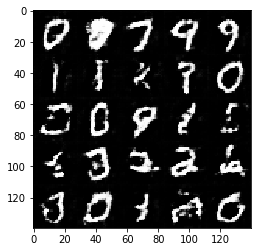

Epoch 2/2... Discriminator Loss: 0.9527... Generator Loss: 0.9484
Epoch 2/2... Discriminator Loss: 0.7136... Generator Loss: 1.3512
Epoch 2/2... Discriminator Loss: 0.7141... Generator Loss: 1.8259
Epoch 2/2... Discriminator Loss: 0.6098... Generator Loss: 1.7638
Epoch 2/2... Discriminator Loss: 1.1257... Generator Loss: 0.8082


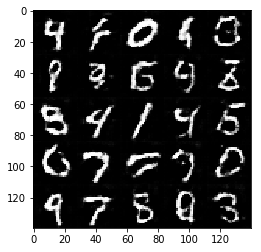

Epoch 2/2... Discriminator Loss: 1.4203... Generator Loss: 0.5506
Epoch 2/2... Discriminator Loss: 0.6174... Generator Loss: 2.6101
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 1.0143
Epoch 2/2... Discriminator Loss: 0.7320... Generator Loss: 1.4462
Epoch 2/2... Discriminator Loss: 0.5198... Generator Loss: 2.0955


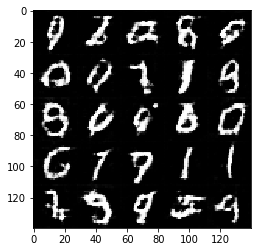

Epoch 2/2... Discriminator Loss: 0.8102... Generator Loss: 1.3633
Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 1.0799
Epoch 2/2... Discriminator Loss: 0.5784... Generator Loss: 2.0053
Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 0.8710
Epoch 2/2... Discriminator Loss: 0.7724... Generator Loss: 2.4676


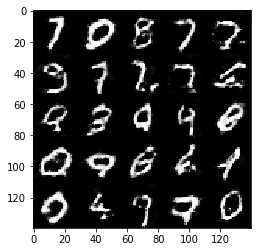

Epoch 2/2... Discriminator Loss: 0.8550... Generator Loss: 1.1325
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 0.8549


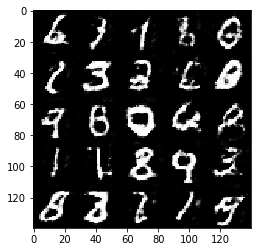

In [75]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 7.9564... Generator Loss: 0.0023
Epoch 1/1... Discriminator Loss: 0.5669... Generator Loss: 3.5360
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 3.9125
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 2.4017


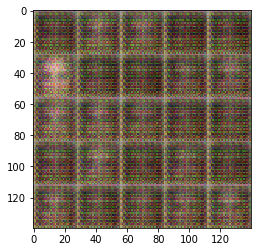

Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 2.6299
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.1728
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 1.7421


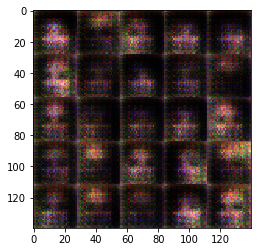

Epoch 1/1... Discriminator Loss: 1.6971... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 3.2160
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 2.4945
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.4335
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.6198


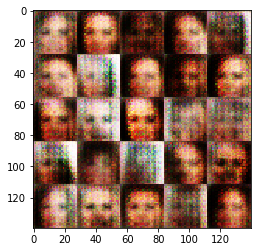

Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 2.1740
Epoch 1/1... Discriminator Loss: 3.1649... Generator Loss: 9.0602
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 2.9174
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.3766


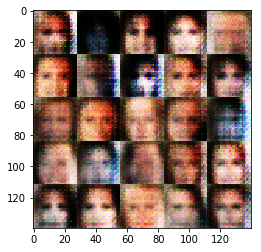

Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.4234
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 3.8048
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 2.3854


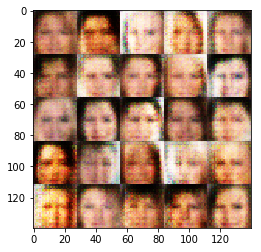

Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.8555
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 2.7174
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 2.4952


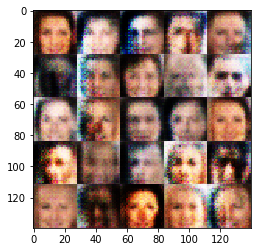

Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 1.5157
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 2.8607
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.8661


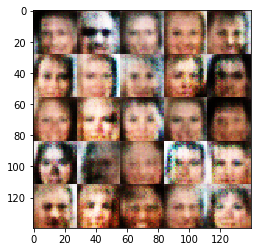

Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.7759
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 1.8834
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 2.3807
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 2.2052
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.4644


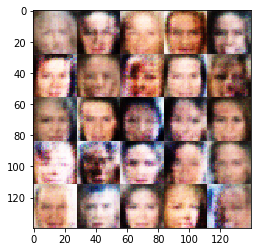

Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.8385
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 3.6131
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.8426


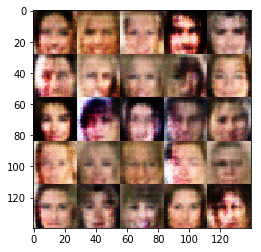

Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 2.9178
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 1.0572


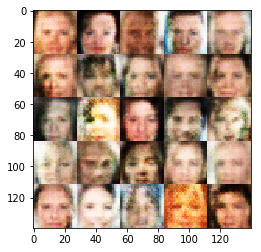

Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.3868
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 0.9912


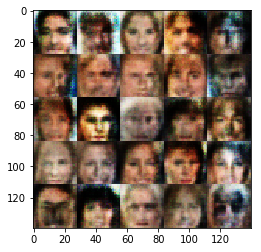

Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.9623... Generator Loss: 4.0200


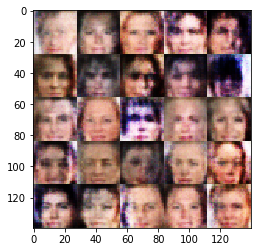

Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 2.4127
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.3806
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 1.6257
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.4540
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.6034


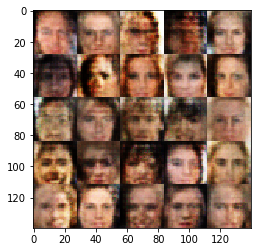

Epoch 1/1... Discriminator Loss: 1.6252... Generator Loss: 0.3779
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 1.4275
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 2.8972


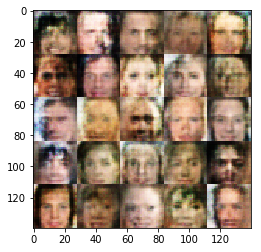

Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.3558


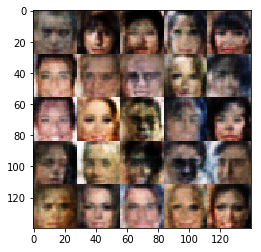

Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.8342
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 1.4616
Epoch 1/1... Discriminator Loss: 1.6467... Generator Loss: 0.3810
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.4794
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.0710


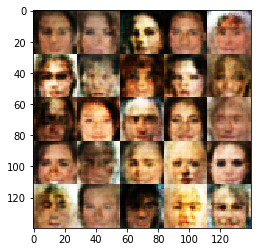

Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 1.7100
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.6895
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.4149


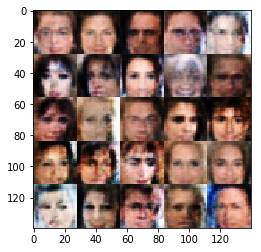

Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.7450
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 2.1412


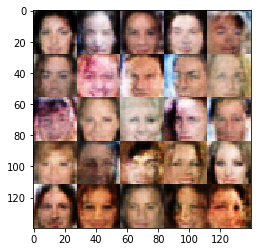

Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 1.5740
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.9674
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.7909


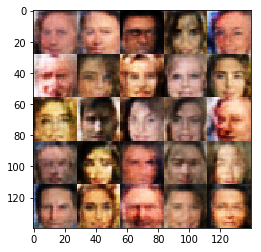

Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.3381
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.5966


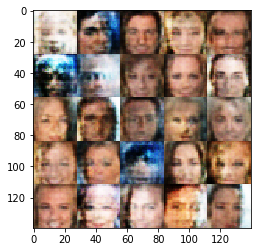

Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.4164
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 2.3681
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.8192
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.5829
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.5225


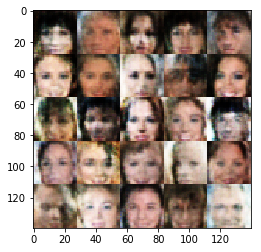

Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 2.0375
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.9707


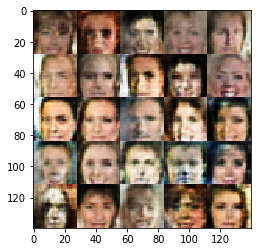

Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 1.5532
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 2.2838
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.4457
Epoch 1/1... Discriminator Loss: 2.0312... Generator Loss: 0.2686


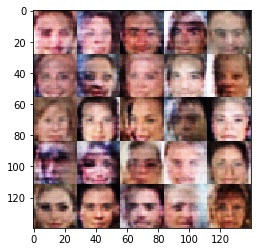

Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.4012
Epoch 1/1... Discriminator Loss: 1.9640... Generator Loss: 0.3419
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.5911
Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 1.6872
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.6013


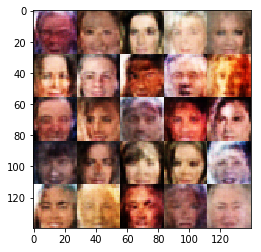

Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 1.9710
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.9487
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.2144


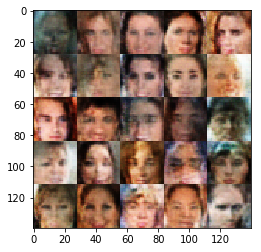

Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.7072
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.9571


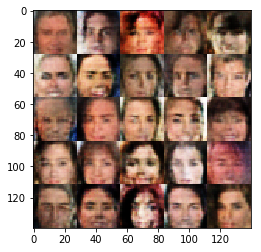

Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 2.1225


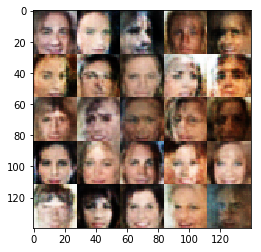

Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.9464
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 1.6756


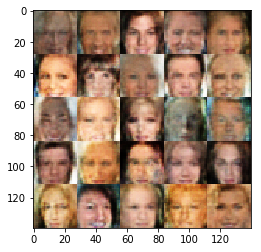

Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.4588
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.1122


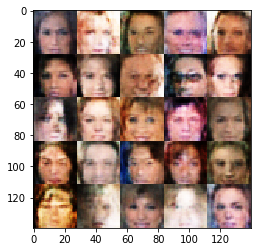

Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.5651


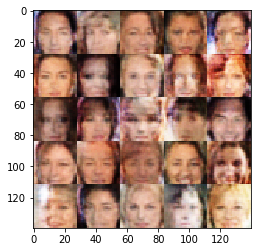

Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.3316
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.3314
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 1.0942


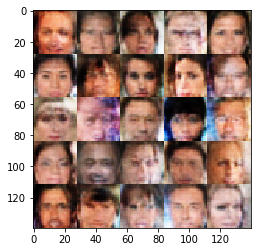

Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 1.5674
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.5969


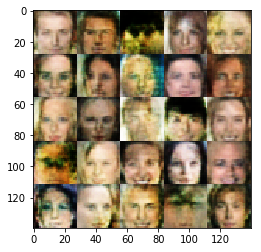

In [76]:
# looks ok - Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.8628
# batch_size = 64
# z_dim = 100
# learning_rate = 0.0001
# beta1 = 0.5

# awful Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 2.8069
# batch_size = 128
# z_dim = 100
#l earning_rate = 0.0002
# beta1 = 0.5

# learning too carefully
# batch_size = 128
# z_dim = 100
# learning_rate = 0.00005
# beta1 = 0.5

batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.